# Overview

Simple demo with flu model with "toy" (not necessarily realistic or finalized) parameters

We go over
- How to set up subpopulation models and metapopulation models.
- How to run accept-reject algorithm.
- How to run experiments to organize output of multiple replications. 

# Imports

In [1]:
# Misc: suppress SSE4.2 deprecation warnings
# This is not an error, just a warning about future hardware compatibility (not relevant in general)
import os
os.environ["MKL_DEBUG_CPU_TYPE"] = "5" 

from pathlib import Path
import numpy as np
import pandas as pd

# Import city-level transmission base components module
import clt_toolkit as clt

# Import flu model module, which contains customized subclasses
import flu_core as flu

import json

# Reading Input Files

In [2]:
# Note that this can be cumbersome due to the complexity of the model 
# Users may prefer to create the model inputs or even the models themselves in a separate .py file and import them! 

# Obtain path to folder with JSON input files
base_path = clt.utils.PROJECT_ROOT / "flu_instances" / "texas_input_files"

# Get filepaths
compartments_epi_metrics_init_vals_filepath = base_path / "init_vals.json"
subpop_params_filepath = base_path / "common_subpop_params.json"
mixing_params_filepath = base_path / "mixing_params.json"
simulation_settings_filepath = base_path / "simulation_settings.json"

calendar_df = pd.read_csv(base_path / "school_work_calendar.csv", index_col=0)
humidity_df = pd.read_csv(base_path / "absolute_humidity_austin_2023_2024.csv", index_col=0)
vaccines_df = pd.read_csv(base_path / "daily_vaccines_constant.csv", index_col=0)

schedules_info = flu.FluSubpopSchedules(absolute_humidity=humidity_df,
                                        flu_contact_matrix=calendar_df,
                                        daily_vaccines=vaccines_df)

# Read in files as dictionaries and dataframes.
# Note that we can also create these dictionaries directly
#   rather than reading from a predefined input data file.
state = clt.make_dataclass_from_json(compartments_epi_metrics_init_vals_filepath,
                                     flu.FluSubpopState)
params = clt.make_dataclass_from_json(subpop_params_filepath, flu.FluSubpopParams)
mixing_params = clt.make_dataclass_from_json(mixing_params_filepath, flu.FluMixingParams)
settings = clt.make_dataclass_from_json(simulation_settings_filepath, flu.SimulationSettings)

# Create two independent bit generators
bit_generator = np.random.MT19937(88888)
jumped_bit_generator = bit_generator.jumped(1)

# Creating Subpopulation Models

In [3]:
# Create two subpopulation models, one for the north
#   side of the city and one for the south side of the city
# In this case, these two (toy) subpopulations have the
#   same demographics, initial compartment and epi metric values,
#   fixed parameters, and school-work calendar.
# If we wanted the "north" subpopulation and "south"
#   subpopulation to have different aforementioned values,
#   we could read in two separate sets of files -- one
#   for each subpopulation.
north = flu.FluSubpopModel(state,
                           params,
                           settings,
                           np.random.Generator(bit_generator),
                           schedules_info,
                           name="north")

south = flu.FluSubpopModel(state,
                           params,
                           settings,
                           np.random.Generator(jumped_bit_generator),
                           schedules_info,
                           name="south")

# If a metapopulation model has N subpopulations that have most of their parameters in common,
#    users can make a JSON file with common parameters, and N smaller JSON files with
#    parameters that are specific to each subpopulation.
# We recommend using `clt_toolkit / utils` functions `updated_dataclass()` and `updated_dict()` for this.

# Modifying Parameters

In [4]:
# We can also manually change a fixed parameter value
#   after we have created a SubpopModel -- like so...
# Note that this is quite a large and unrealistic value of
#   beta_baseline, but we'll use this to create
#   a dramatic difference between the two subpopulations.
south.params = clt.updated_dataclass(south.params, {"beta_baseline": 10})

# The structure of the code allows us to access
#   the current state and fixed parameters of each
#   subpopulation model.
# For example, here we print out the fixed parameter
#   value for beta_baseline for the "south" subpopulation.
print(south.params.beta_baseline)

10


# Create Metapopulation Model

In [5]:
# Combine two subpopulations into one metapopulation model (travel model)
flu_demo_model = flu.FluMetapopModel([north, south],
                                     mixing_params)

# Simulation and Analysis

In [6]:
# Simulate for 50 days
flu_demo_model.simulate_until_day(50)

# Get the current real date of the simulation and the
#   current simulation day
print(flu_demo_model.current_simulation_day)
print(flu_demo_model.current_real_date)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
50
2022-09-27


In [7]:
# Simulate for another 50 days, from where we last left off
flu_demo_model.simulate_until_day(100)

# We can "unpack" our flu model and access the current state
#   of each subpopulation -- here's an example with the "north"
#   subpopulation -- this is the state after we have simulated
#   our 100 days.
print(flu_demo_model.north.state)

# This is equivalent to calling `flu_demo_model.subpop_models.north.state`.
# Under the hood, CLT Toolkit uses "attribute delegation" to make the syntax easier and avoid nested attribute calls.

FluSubpopState(S=array([[ 224479.],
       [ 361909.],
       [1136938.],
       [ 504254.],
       [ 616566.]]), E=array([[ 143018.0000071 ],
       [ 452720.        ],
       [1062292.        ],
       [ 400290.00000031],
       [ 299275.00000238]]), IP=array([[ 19397.66020355],
       [ 61392.98684111],
       [144062.83722082],
       [ 54286.42316793],
       [ 40592.51007934]]), IS=array([[ 40988.95971282],
       [129602.50788896],
       [304246.41969418],
       [114719.72735797],
       [ 86744.85055497]]), IA=array([[ 20297.95971225],
       [ 64232.42294914],
       [150736.41969418],
       [ 56804.72647801],
       [ 42482.90575631]]), H=array([[ 124.76766706],
       [ 185.67067381],
       [ 791.61477608],
       [ 499.64488481],
       [3787.53341619]]), R=array([[ 1465719.22501648],
       [ 4556980.84235822],
       [10763955.78230235],
       [ 4074170.05193184],
       [ 3103618.18447355]]), D=array([[   6.55250789],
       [   6.55250789],
       [   6.55250789],


In [8]:
# Remember that we can easily access the objects that
#   make up our subpopulation model -- here's an
#   example of accessing the "north" subpopulation's
#   compartments.
# See API references for more attribute access syntax.
print(flu_demo_model.subpop_models.north.compartments)

#0. 'S':  <clt_toolkit.base_components.Compartment object at 0x180bd8f50>
#1. 'E':  <clt_toolkit.base_components.Compartment object at 0x177382ad0>
#2. 'IP': <clt_toolkit.base_components.Compartment object at 0x180bd9810>
#3. 'IS': <clt_toolkit.base_components.Compartment object at 0x1752c6fd0>
#4. 'IA': <clt_toolkit.base_components.Compartment object at 0x180bd8f90>
#5. 'H':  <clt_toolkit.base_components.Compartment object at 0x180489d90>
#6. 'R':  <clt_toolkit.base_components.Compartment object at 0x180bd8c10>
#7. 'D':  <clt_toolkit.base_components.Compartment object at 0x10db76cd0>


In [9]:
# Here's the current state of the "S" compartment for the "north" subpopulation
print(flu_demo_model.north.S.current_val)

# Again, due to attribute delegation, this syntax is equivalent to
# flu_demo_model.subpop_models.north.compartments.S.current_val

[[ 224479.]
 [ 361909.]
 [1136938.]
 [ 504254.]
 [ 616566.]]


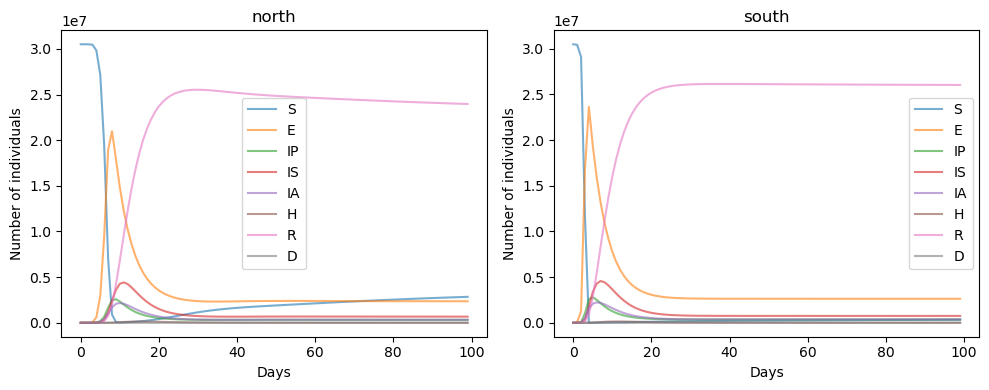

In [10]:
# Generate simple compartment history plot for flu model
clt.plot_metapop_basic_compartment_history(flu_demo_model)

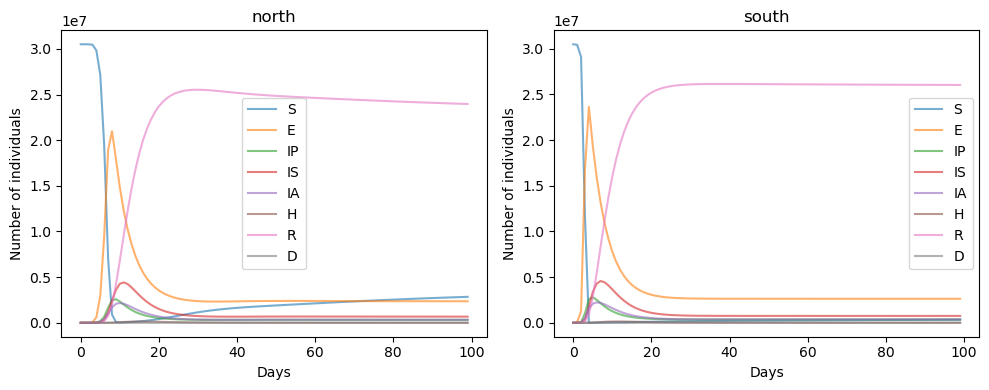

In [11]:
# Reset the simulation
# Note -- does NOT reset the RNG! Only clears each object's
#   history, resets the simulation day/date to the starting
#   day/date, and returns state variables to their initial values.
flu_demo_model.reset_simulation()

# Set school and work contact matrices to zero matrices for both
#   subpopulations and demonstrate that this removes the calendar-induced
#   periodicity.
num_age_groups = flu_demo_model.subpop_models.north.params.num_age_groups

for subpop_model in flu_demo_model.subpop_models.values():
    subpop_model.params = clt.updated_dataclass(subpop_model.params,
                                                {"school_contact_matrix": np.zeros((num_age_groups, num_age_groups)),
                                                 "work_contact_matrix": np.zeros((num_age_groups, num_age_groups))})

flu_demo_model.simulate_until_day(100)

clt.plot_metapop_basic_compartment_history(flu_demo_model)

# Accept Reject

In [12]:
# Distinct RNG for random sampling
accept_reject_RNG = np.random.Generator(bit_generator.jumped(2))

# See `clt_toolkit / sampling / sample_uniform_metapop_params` docstring for `sampling_spec` details.
# Here, we want to sample `IP_relative_inf`, which is a scalar, from a Uniform[1,3] distribution.
# We want this value to be the same across all subpopulations.
sampling_spec = {"all_subpop": {"IP_relative_inf": clt.UniformSamplingSpec(1, 3, "scalar")}}

# Here we will create some artificial "target admits".
# We want sampled parameters that generate hospital admits close to these target admits.
flu_demo_model.reset_simulation()
flu_demo_model.modify_simulation_settings({"transition_variables_to_save": ["IS_to_H"]})
flu_demo_model.simulate_until_day(50)

# Transition variables' histories get saved for each timestep.
# We use this function convert per-timestep hospital admits to per-day hospital admits.
target_admits = clt.aggregate_daily_tvar_history(flu_demo_model, "IS_to_H")

# Perform accept reject -- see docstring for more details and additional parameters 
#    (that are not shown because set to defaults).
# If target admits is over 50 days, then we need to simulate 50 days for the accept-reject algorithm as well.
flu.accept_reject_admits(flu_demo_model,
                         accept_reject_RNG,
                         sampling_spec,
                         target_admits,
                         num_days = 50,
                         target_accepted_reps = 2,
                         max_reps = 20)

In [13]:
# This command-line function shows the `JSON` files that `accept_reject_admits` generates.
!ls *accepted*

subpop_north_rep_1_accepted_sample_params.json
subpop_north_rep_1_accepted_state.json
subpop_north_rep_2_accepted_sample_params.json
subpop_north_rep_2_accepted_state.json
subpop_south_rep_1_accepted_sample_params.json
subpop_south_rep_1_accepted_state.json
subpop_south_rep_2_accepted_sample_params.json
subpop_south_rep_2_accepted_state.json


In [14]:
# Here's the state of the "north" subpopulation in accepted replication #1, at simulation time 50.
# We can load this into a `FluSubpopParams` instance and use it to create a new `FluSubpopModel` instance in the future.
with open("subpop_north_rep_1_accepted_state.json", "r") as f:
    north_rep_1_state = json.load(f) 
print(north_rep_1_state)

{'S': [[174092.0], [281180.0], [884299.0], [392143.0], [476414.0]], 'E': [[140945.0000263974], [451118.0000000056], [1055501.0], [396566.0000008466], [290584.0000071032]], 'IP': [[19052.90590408648], [61108.11542757577], [142854.98683696776], [53642.50903978245], [39206.66026762675]], 'IS': [[39950.10424718063], [128613.58719473658], [300186.5078889569], [112672.84949555527], [83445.95996928099]], 'IA': [[19827.10361643386], [63791.509386130376], [148907.4229491388], [55868.90376192698], [40683.01048619242]], 'H': [[238.87698371791703], [327.7676670594374], [1533.6949215435052], [971.7434248492682], [7356.61744834327]], 'R': [[1519920.3114671498], [4640884.952629312], [11029740.842375442], [4193160.1101912726], [3255476.264088372]], 'D': [[5.860786223465865], [5.860786223465865], [5.860786223465865], [5.860786223465865], [1863.2279879640469]], 'M': [[0.47003966803705494], [0.48516963698746796], [0.47783748244390395], [0.4739712931627899], [0.4566552831924237]], 'MV': [[0.00236826961596

In [15]:
# Here are the SAMPLED parameters of the "north" and "south" subpop models in accepted replication #1.
# Recall that we specified that this sampled value should be the same across all subpopulations -- and we confirm this below.

with open("subpop_north_rep_1_accepted_sample_params.json", "r") as f:
    north_rep_1_params = json.load(f) 
print(north_rep_1_params)

with open("subpop_south_rep_1_accepted_sample_params.json", "r") as f:
    south_rep_1_params = json.load(f) 
print(south_rep_1_params)

{'IP_relative_inf': 1.35}
{'IP_relative_inf': 1.35}


# Experiments

In [16]:
# Create an experiment class to record "H" and "D" compartment values
experiment = clt.Experiment(model = flu_demo_model, 
                            state_variables_to_record = ["H", "D"], 
                            database_filename = "flu_demo_H_D_results.db")

# Run the simulation for 10 independent replications, for 100 days, and save the values of
#    "H" and "D" every 7 days. Save the results in a CSV file. 
experiment.run_static_inputs(num_reps = 10, 
                             simulation_end_day = 100, 
                             days_between_save_history = 7, 
                             results_filename = "flu_demo_H_D_results.csv")

In [17]:
# Here's the CSV we just created -- pretty nifty! :) 
H_D_results_df = pd.read_csv("flu_demo_H_D_results.csv", index_col=0)

H_D_results_df.head()

,subpop_name,state_var_name,age_group,risk_group,rep,timepoint,value
0,north,H,0,0,0,7,6.897341
1,north,H,1,0,0,7,18.812830
2,north,H,2,0,0,7,56.743385
3,north,H,3,0,0,7,28.789684
4,north,H,4,0,0,7,136.644885


In [18]:
# `run_static_inputs` also creates a SQL database with the large-scale output from our experiment.
!ls *.db*

flu_demo_H_D_results.db


In [19]:
# Build dataframe of "H" state based on experiment run above (simulated 100 days, state saved every 7 days).
# See `get_state_var_df()` docstring for details. 
# Because we do not specify `subpop_name`, `age_group`, or `risk_group`, 
#     compartment values are summed across subpopulations, ages, and risk groups.
experiment.get_state_var_df(state_var_name = "H",
                            results_filename = "flu_demo_aggregated_H_results.csv")

timepoint,7,14,21,28,35,42,49,56,63,70,77,84,91,98,100
rep,,,,,,,,,,,,,,,
0,34279.155588,232715.155746,199015.155746,100107.155746,50594.155746,30326.155746,22063.155746,18272.155746,16173.155746,14743.155746,13572.155746,12724.155746,12043.155746,11387.155746,11249.155746
1,34279.155588,232715.155746,199015.155746,100107.155746,50594.155746,30326.155746,22063.155746,18272.155746,16173.155746,14743.155746,13572.155746,12724.155746,12043.155746,11387.155746,11249.155746
2,34279.155588,232715.155746,199015.155746,100107.155746,50594.155746,30326.155746,22063.155746,18272.155746,16173.155746,14743.155746,13572.155746,12724.155746,12043.155746,11387.155746,11249.155746
3,34279.155588,232715.155746,199015.155746,100107.155746,50594.155746,30326.155746,22063.155746,18272.155746,16173.155746,14743.155746,13572.155746,12724.155746,12043.155746,11387.155746,11249.155746
4,34279.155588,232715.155746,199015.155746,100107.155746,50594.155746,30326.155746,22063.155746,18272.155746,16173.155746,14743.155746,13572.155746,12724.155746,12043.155746,11387.155746,11249.155746
5,34279.155588,232715.155746,199015.155746,100107.155746,50594.155746,30326.155746,22063.155746,18272.155746,16173.155746,14743.155746,13572.155746,12724.155746,12043.155746,11387.155746,11249.155746
6,34279.155588,232715.155746,199015.155746,100107.155746,50594.155746,30326.155746,22063.155746,18272.155746,16173.155746,14743.155746,13572.155746,12724.155746,12043.155746,11387.155746,11249.155746
7,34279.155588,232715.155746,199015.155746,100107.155746,50594.155746,30326.155746,22063.155746,18272.155746,16173.155746,14743.155746,13572.155746,12724.155746,12043.155746,11387.155746,11249.155746
8,34279.155588,232715.155746,199015.155746,100107.155746,50594.155746,30326.155746,22063.155746,18272.155746,16173.155746,14743.155746,13572.155746,12724.155746,12043.155746,11387.155746,11249.155746
